# Gaussian Naive Bayes for Digit Recognition
In this exercise we implement Gaussian Naive Bayes using the digit recognition data set available from the sklearn module [Scikit-Learn.org](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) | [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)

In [1]:
import sklearn
from sklearn import datasets
digits = datasets.load_digits()
print("dataset imported from",type(digits))

dataset imported from <class 'sklearn.utils.Bunch'>


#### The data is made of 8x8 vectors of digit images

In [2]:
print("digits =",digits.images.shape)

digits = (1797, 8, 8)


In [3]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

#### To apply a classifier on this data, we need to flatten the image

In [4]:
x = digits.images
x = x.reshape((digits.images.shape[0],-1))
print("x =",x.shape)

x = (1797, 64)


$\vec{x}$ represents the image vector $(x_1, x_2, x_3, … ,x_{64})$.

In [5]:
x[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

#### Let's take a look at the dataset

label:  0


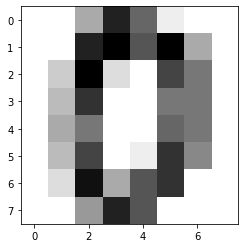

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
print("label: ",digits.target[0])
imgplot = plt.imshow(digits.images[0],cmap=plt.cm.binary)

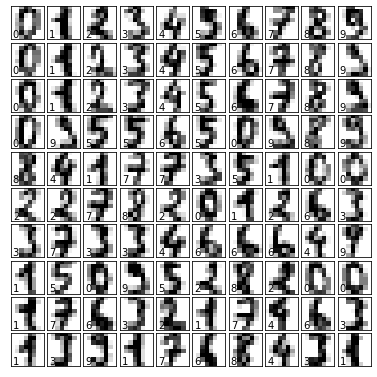

In [7]:
grid = plt.figure(figsize=(5,5))
grid.subplots_adjust(left=1,right=2,bottom=1,top=2,hspace=0.1,wspace=0.1)
for t in range(100):
    fig = grid.add_subplot(10,10,t+1,xticks=[],yticks=[])
    fig.imshow(digits.images[t],cmap=plt.cm.binary)
    fig.text(0,7,str(digits.target[t]))

### The classes of objects we are trying to identify

$\qquad c_k \in \mathbb{Z}(0 \le k \le 9)$.

In [8]:
classes = list(set(digits.target))
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

### Split the training data and the test data

In [9]:
import random

split_ratio = 0.7
training_data_size = int(len(x)*split_ratio)
train,test,train_data,train_label = [],[],[],[]
test_data,test_label = list(x),list(digits.target)

while len(train) < training_data_size:
    i = random.randrange(len(test_label))
    train_data.append(test_data.pop(i))
    train_label.append(test_label.pop(i))
    train.append([train_data[len(train_data)-1],train_label[len(train_label)-1]])
    
for j in test_label:
    test.append([test_data[len(test_data)-1],test_label[len(test_label)-1]])
    
print("Size of the training dataset:",len(train))
print("Size of the test dataset:",len(test))

Size of the training dataset: 1257
Size of the test dataset: 540


$c_k$ represents class $k$, one of the $10$ digits for recognition. Recall, we’re looking for the highest $p(c_k|\vec{x})$ by using this fact:

$\qquad p(c_k|\vec{x}) = \dfrac{p(\vec{x}|c_k) p(c_k)}{p(\vec{x})}$.

In a bayes classifier we calculate the posterior for every $c_k$ for each $x_i$. Then, classify the observation based on the class with the largest value.

### Calculate the Priors

$p(c_k)$ is the proportion of that class in the training data. E.g. if there are $20$ <font color='red'>five</font>s out of $200$ digits in the training sample:

$\qquad p($<font color='red'>five</font>$)$ $= \dfrac{20}{200} = \dfrac{1}{10} = 0.1$.

In [10]:
prior_c = {}
for k in classes:
    prior_c[k] = train_label.count(k)/len(train)
    
print("prior_c = ",prior_c)

prior_c =  {0: 0.10342084327764518, 1: 0.09626093874303898, 2: 0.10023866348448687, 3: 0.10023866348448687, 4: 0.10501193317422435, 5: 0.10103420843277645, 6: 0.09626093874303898, 7: 0.09626093874303898, 8: 0.09466984884645982, 9: 0.10660302307080351}


$p(\vec{x}|c_k)$ is more complicated. The main assumption of Naive Bayes is that the features should be treated independently (which is why it’s “naive”).

$\qquad p(\vec{x}|c_k) = p(x_1|c_k) * p(x_2|c_k) * … * p(x_{64}|c_k) = \Pi_{i=1}^{64} p(x_i|c_k)$.

#### For each class, $k$, in the training data calculate the $\mu$ and $\sigma$ of each pixel location

In [11]:
import numpy as np

train_data = np.array(train_data)
mean_c,std_c = {},{}
for k in classes:
    i = np.where(train_label[:len(train_label)]==k)[0]
    mean_c[k] = np.mean(train_data[i,:],axis=0)
    std_c[k] = np.std(train_data[i,:],axis=0)

Use that and the formula for a gaussian probability to calculate $p(x_i|c_k)$.
        
$\qquad g(x) = \dfrac{1}{\sigma \sqrt{2\pi}} \exp\biggl(\dfrac{-1}{2} \biggl(\dfrac{x-\mu}{\sigma}\biggr)^2\biggr)$.

The standard deviation is <font color='red'>undefined</font> when there is only one value for the feature. In this case, we can use a small value to avoid execution error, e.g. 0.00001.

In [12]:
def probability_distribution(pixel_value, mean, std):
    if std == 0: 
        std = 0.00001
    return (1/(np.sqrt(2*np.pi*std**2)))*np.exp((-(pixel_value-mean)**2)/(2*std**2))

$p(\vec{x})$ is the normalization term. We don’t need to calculate this, since we just want to pick the largest $p(c_k|\vec{x})$, and $p(\vec{x})$ is the same denominator in calculating $p(c_k|\vec{x})$ for every class.

$\qquad p(\vec{x})   = \sum_{k} p(\vec{x},c_k)   = \sum_{k} p(\vec{x}|c_k) p(c_k)$.

So, let's ignore the marginal probability.

$\qquad p(c_k|\vec{x}) = \dfrac{p(\vec{x}|c_k) p(c_k)}{p(\vec{x})} \approx p(\vec{x}|c_k) p(c_k)$.

### Test the model

In [13]:
predictions = []
for image in test_data:
    max_posterior,prediction = 0,0
    for k in classes:
        numerator_of_posterior,posterior = 1,1
        for i,pixel_value in enumerate(image):
            mean = mean_c[k][i]
            stdev = std_c[k][i]
            numerator_of_posterior *= probability_distribution(pixel_value, mean, stdev)
        posterior = numerator_of_posterior * prior_c[k]
        if posterior > max_posterior:
            max_posterior = posterior
            prediction = k
    predictions.append(prediction)

### 1. Report the overall accuracy of your prediction.

In [14]:
def getAccuracy(testSet,predictions):
    correct = 0
    for i in range(len(testSet)):
        if testSet[i] == predictions[i]:
            correct += 1
    return (correct/float(len(testSet))) * 100.0

accuracy = getAccuracy(test_label,predictions)
print("Accuracy percentage: {}%".format(accuracy))

Accuracy percentage: 73.33333333333333%


### 2. Show the classification matrix.

In [15]:
from sklearn import metrics
print(metrics.classification_report(predictions,test_label))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        51
           1       0.93      0.58      0.71        99
           2       0.39      0.80      0.53        25
           3       0.53      0.97      0.68        31
           4       0.45      0.96      0.61        23
           5       0.91      0.82      0.86        61
           6       0.97      0.95      0.96        61
           7       0.97      0.60      0.74        93
           8       0.51      0.42      0.46        67
           9       0.59      0.93      0.72        29

    accuracy                           0.73       540
   macro avg       0.72      0.80      0.72       540
weighted avg       0.81      0.73      0.74       540



#### confusion matrix

In [16]:
print(metrics.confusion_matrix(predictions,test_label))
plt.show()

[[48  1  0  0  1  0  0  0  0  1]
 [ 0 57  9  3  4  1  1  0 18  6]
 [ 0  0 20  2  0  0  1  0  1  1]
 [ 0  0  0 30  0  1  0  0  0  0]
 [ 0  0  0  0 22  0  0  1  0  0]
 [ 0  0  2  6  0 50  0  0  1  2]
 [ 0  0  0  0  2  1 58  0  0  0]
 [ 0  1  0  3 20  1  0 56  7  5]
 [ 0  1 20 13  0  1  0  0 28  4]
 [ 0  1  0  0  0  0  0  1  0 27]]


### 3. Note which errors are more common. In what way does that match your intuitions?

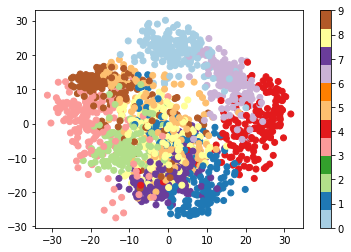

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(digits.data)
plt.scatter(proj[:,0],proj[:,1],c=digits.target,cmap="Paired")
plt.colorbar()
plt.show()

- There is clustering of the $2$, $3$, $8$ and $9$ digits which have similar shapes and the highest rates of false positives. This lends to the intuition behind the high association rate in the probability distribution.

- The highest inaccurate association rate in the confusion matrix tends to be between the $3$ and the $8$. This makes sense because the shape of a $3$ follow an incomplete $8$ outline. This might also follow high association rates between the $2$ or $4$; and the $8$ digit.

- Another high inaccurate association rate in the confustion matrix is the association of $4$ with $7$. This data set features $7$ digits often with a slash which make them appear as disconnected $4$s.